## Makes basic test of the input CatSim catalog, Issue #4

This makes very basic test on the input catalog.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
#big enough figures
plt.rcParams['figure.figsize'] = 10,6
plt.rcParams['font.size']= 22
import astropy
import os,sys

In [2]:
#fix fname below to whatever you want it to be
try:
    root=os.environ["DESC_LSS_ROOT"]
except KeyError:
    root="/project/projectdirs/lsst/LSSWG"
fname=root+"/DC1/TestCat/test_80sq_degree_galaxy_catalog.txt"

#circle coordinates, in degress, see issue #3
cent_ra=120
cent_dec=-10
radius=5.16

# Cosmology
omega_matter = 0.25
Omega_baryon = 0.045
Omega_curvature = 0
H0 = 73
sigma_8 = 0.9
n_s = 1
from astropy.cosmology import FlatLambdaCDM
cosmo=FlatLambdaCDM(H0=H0,Om0=omega_matter)

In [37]:
## We really should not distribute files this large in
## csv format. csv 
##
ra,dec,redshift,ugrizy=[],[],[],[]
f=open(fname)
print f.readline()
cc=0
skip3=True
while True: 
    ## skipping
    if skip3:
        f.readline()
        f.readline()
        f.readline()
    line=f.readline()
    if len(line)>0:
        line=map(float, line.split(','))
        ra.append(line[0])
        dec.append(line[1])
        redshift.append(line[2])
        ugrizy.append(line[3:9])
        cc+=1
        if (cc%1000000==0):
            print "Read (millions):",cc/1000000
    else:
        break
        
f.close()

#raJ2000, decJ2000, redshift, u_ab, g_ab, r_ab, i_ab, z_ab, y_ab

Read (millions): 1
Read (millions): 2
Read (millions): 3
Read (millions): 4
Read (millions): 5
Read (millions): 6
Read (millions): 7
Read (millions): 8
Read (millions): 9
Read (millions): 10
Read (millions): 11
Read (millions): 12
Read (millions): 13
Read (millions): 14
Read (millions): 15
Read (millions): 16
Read (millions): 17


In [38]:
ra=np.array(ra)
dec=np.array(dec)
redshift=np.array(redshift)
ugrizy=np.array(ugrizy)
magr=ugrizy[:,2]

## Total object count

In [49]:
Atest=radius**2*np.pi
Atot=20e3
#total objects per survey
totobj=len(magr)/Atest*Atot
#total objects in gold sample (r<)
totgold=(magr<25.3).sum()/Atest*Atot
if skip3:
    totobj*=4
    totgold*=4
print "We are working with:",Atest,"sq deg"
print "If this was a 20k survey, you would have:"
print "Total objects", totobj/1e9, "bil, gold sample",totgold/1e9,"bil"
print "We expect some 4e9 objects in gold sample."
if abs(totgold/4e9-1)>0.1:
    print 'WARNING: number of objects in the gold sample !!'
print "Diameter at z=2:",cosmo.comoving_distance(2.0)*(radius/180*np.pi)
print "Distance to z=4",cosmo.comoving_distance(4.0)
print "Approx volume of this survey: ",(np.pi*cosmo.comoving_distance(4.0)**3*(radius/180*np.pi)**2/3).value/1e9,"Gpc^3"
print "CF. Millenium sim = (500Mpc)^3 = 0.125Gpc^3"

We are working with: 83.6467893574 sq deg
If this was a 20k survey, you would have:
Total objects 17.1648170961 bil, gold sample 2.92209565816 bil
We expect some 4e9 objects in gold sample.
Diameter at z=2: 468.178054012 Mpc
Distance to z=4 7275.51299721 Mpc
Approx volume of this survey:  3.27094784264 Gpc^3
CF. Millenium sim = (500Mpc)^3 = 0.125Gpc^3


## redhift and mag histograms

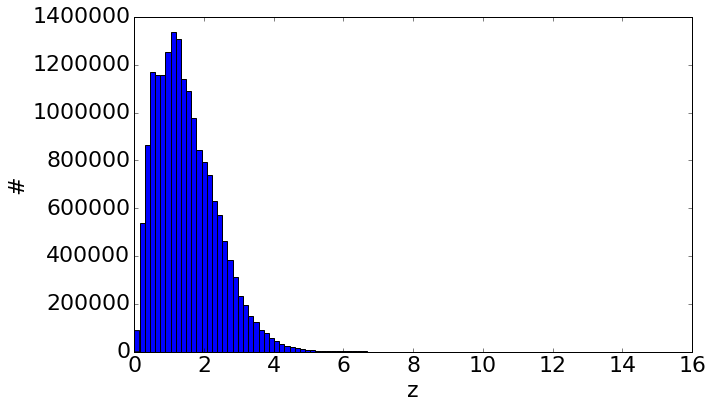

In [13]:
plt.hist(redshift,bins=100)
plt.xlabel('z')
plt.ylabel('#')

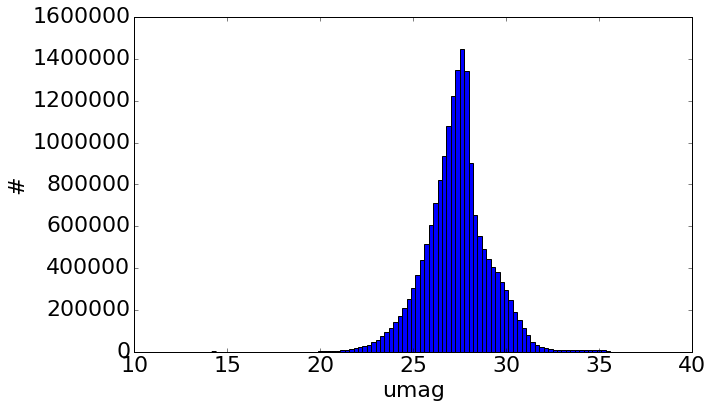

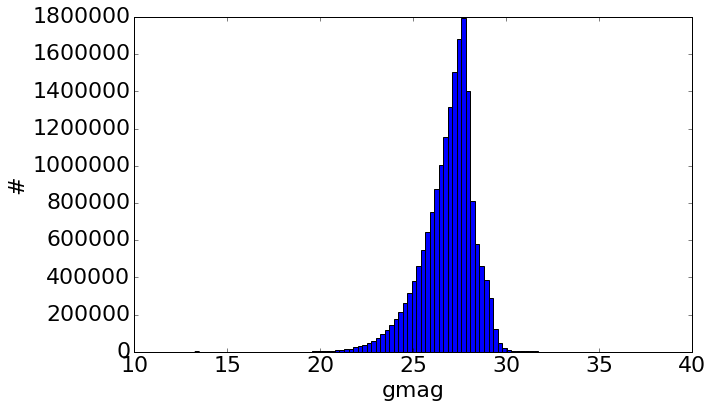

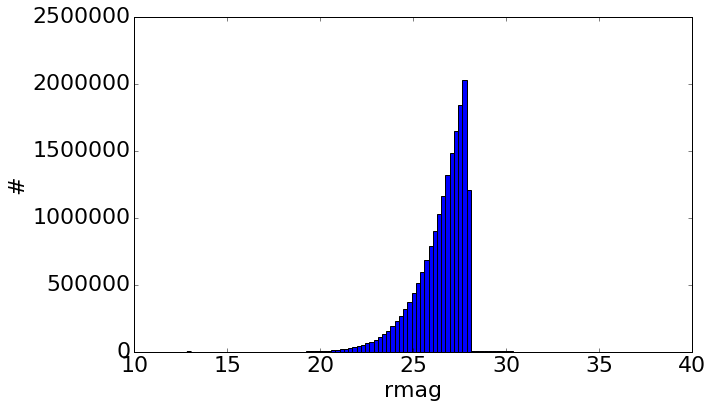

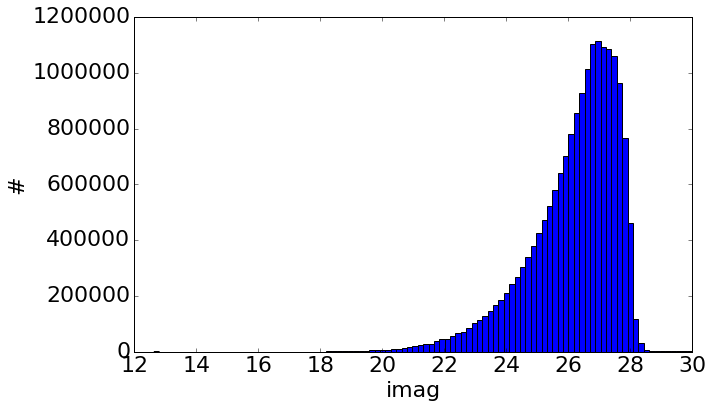

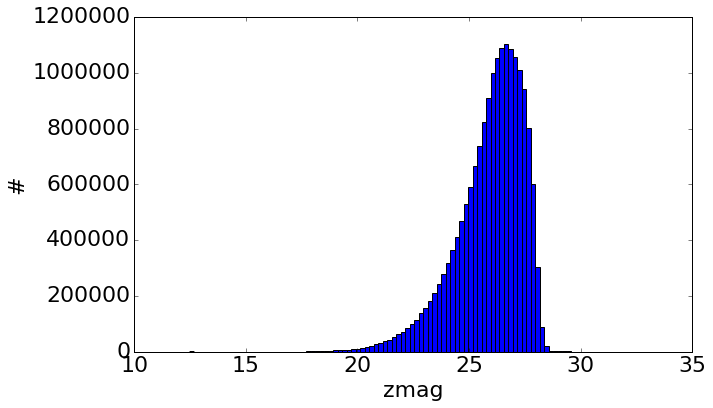

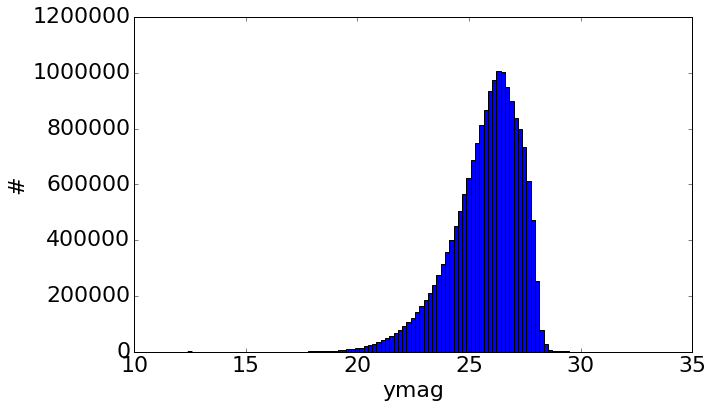

In [14]:
for i,lab in enumerate('ugrizy'):
    plt.figure()
    plt.hist(ugrizy[:,i],bins=100)
    plt.xlabel(lab+"mag")
    plt.ylabel("#")

## generate catalog

In [15]:
print dec.mean(), ra.mean(), cent_dec, cent_ra

-9.98978574255 119.999817163 -10 120


In [16]:
## generate catalog
rad=cosmo.comoving_distance(redshift)
catx=np.cos(dec/180*np.pi)*np.cos(ra/180*np.pi)
caty=np.cos(dec/180*np.pi)*np.sin(ra/180*np.pi)
catz=np.sin(dec/180*np.pi)
cenx=np.cos(cent_dec/180.*np.pi)*np.cos(cent_ra/180.*np.pi)
ceny=np.cos(cent_dec/180.*np.pi)*np.sin(cent_ra/180.*np.pi)
cenz=np.sin(cent_dec/180.*np.pi)


In [17]:
## first sanity check, distribution of angles wrt to center, in degrees
ang=np.arccos((catx*cenx+caty*ceny+catz*cenz))/np.pi*180

Max distance: 5.15666208165 c.f. 5.16


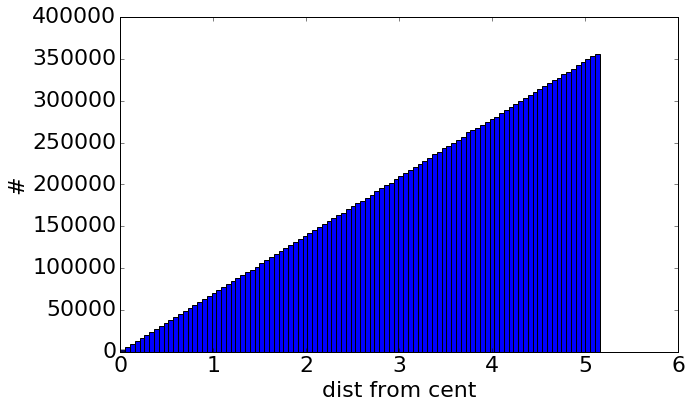

In [18]:
plt.hist(ang,bins=100)
plt.xlabel('dist from cent')
plt.ylabel('#')
print 'Max distance:',ang.max(), "c.f.", radius

In [19]:
## now define an orthonormal system to cenx, ceny, cenz
radvec=[cenx,ceny,cenz]
xortho=np.cross(radvec,[0,0,1])
yortho=np.cross(radvec,xortho)
xortho/=np.sqrt(np.dot(xortho,xortho))
yortho/=np.sqrt(np.dot(yortho,yortho))
print "all zeros:"
print np.dot(xortho,yortho), np.dot(xortho,radvec),np.dot(yortho,radvec)
print "all ones:"
print np.dot(xortho,xortho), np.dot(yortho,yortho)

all zeros:
0.0 0.0 -2.77555756156e-17
all ones:
1.0 1.0


In [87]:
def plotCirc(xx,yy):
    """plots a 2D projected density field for real/random catalogs"""
    img=np.histogram2d(xx/np.pi*180,yy/np.pi*180,range=[[-radius,radius],[-radius,radius]],bins=300)
    plt.figure(figsize=(12,12))    
    plt.imshow(img[0],interpolation='nearest',extent=(-radius,radius,-radius,radius))
    plt.xlabel('xoffset')
    plt.ylabel('yoffset')
    print "Do you see a nice circle?"

In [84]:
#projected values
xes=np.dot(xortho,[catx,caty,catz])
yes=np.dot(yortho,[catx,caty,catz])

In [85]:
# make random catalog.
ranx=np.random.uniform(-radius,radius,len(xes)*2)
rany=np.random.uniform(-radius,radius,len(xes)*2)
choose=np.where((ranx*ranx+rany*rany)<radius**2)
ranx=ranx[choose]
rany=rany[choose]
ranrad=np.array([rad[i].value for i in np.random.randint(len(rad),size=len(ranx))])
ranx*=np.pi/180.
rany*=np.pi/180.


SIGNAL:
Do you see a nice circle?
RANDOMS:
Do you see a nice circle?


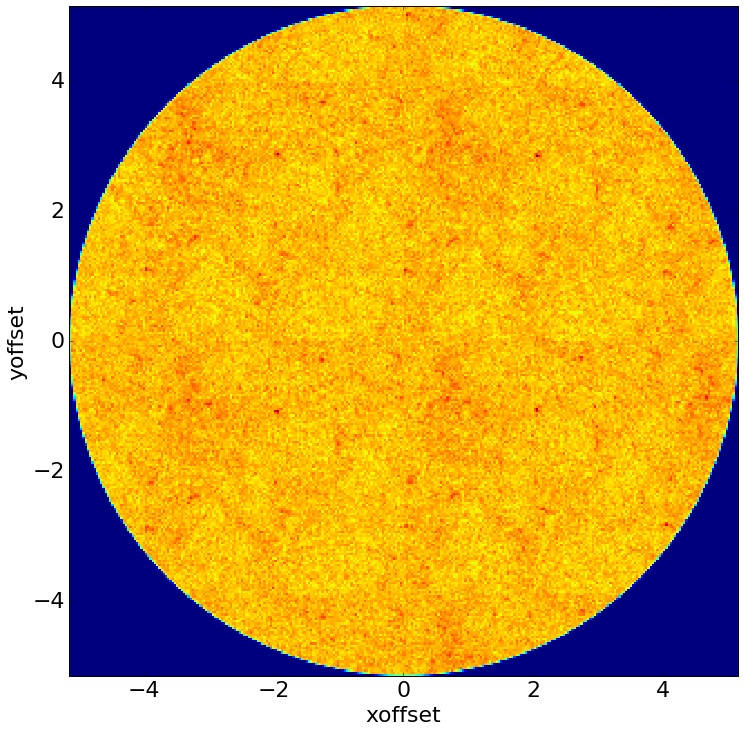

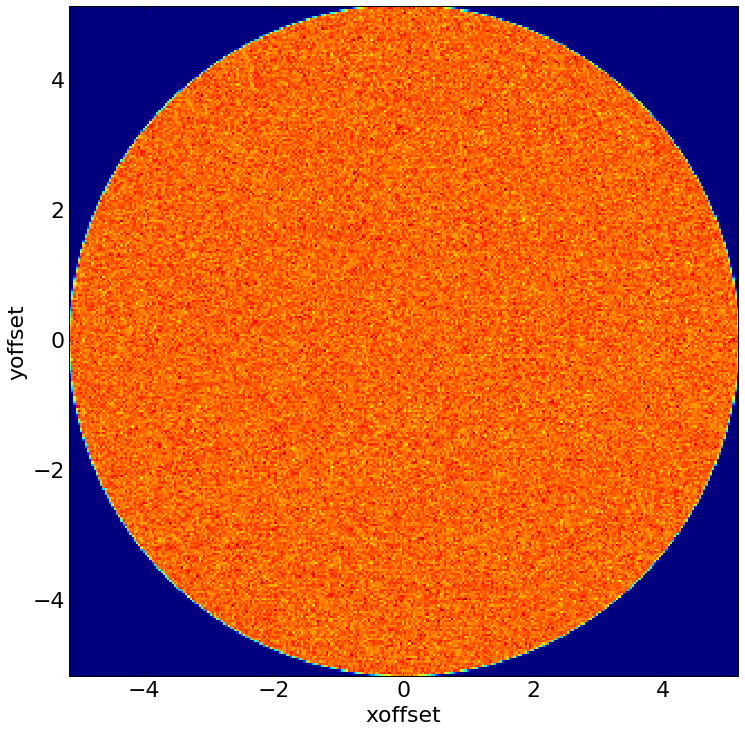

In [89]:
print "SIGNAL:"
plotCirc(xes,yes)
print "RANDOMS:"
plotCirc(ranx,rany)

# correlation function

Let me clarify that use of correlation function in this sanity check by no means implies that I endorse use for correlation function for any serious analysis except when you have very good reasons to.

In [21]:
import treecorr as tc


In [69]:
## Let's do analysis in a couple of z-bins
xires=[]
for zmin,zmax in [(0,0.5),(0.5,1.0), (1.0,1.5),(1.5,3.0)]:
    print "Doing",zmin,"-",zmax
    dimin,dimax=cosmo.comoving_distance([zmin,zmax])
    wh=np.where((rad>dimin)&(rad<dimax))
    sigcat=tc.Catalog(x=xes[wh]*rad[wh],y=yes[wh]*rad[wh],z=rad[wh]*np.sqrt(1-xes[wh]**2-yes[wh]**2))
    whr=np.where((ranrad>dimin.value)&(ranrad<dimax.value))
    rancat=tc.Catalog(x=ranx[whr]*ranrad[whr],y=rany[whr]*ranrad[whr],z=ranrad[whr]*np.sqrt(1-ranx[whr]**2-rany[whr]**2))
    dd=tc.NNCorrelation(min_sep=0.1,bin_size=0.1,max_sep=200.)
    dd.process(sigcat)
    dr=tc.NNCorrelation(min_sep=0.1,bin_size=0.1,max_sep=200.)
    dr.process(sigcat,rancat)
    rr=tc.NNCorrelation(min_sep=0.1,bin_size=0.1,max_sep=200.)
    rr.process(rancat,rancat)
    xi,xivar=dd.calculateXi(rr,dr)
    xires.append((zmin,zmax,np.exp(dd.logr),xi,xivar))


Doing 0 - 0.5
Doing 0.5 - 1.0
Doing 1.0 - 1.5
Doing 1.5 - 3.0


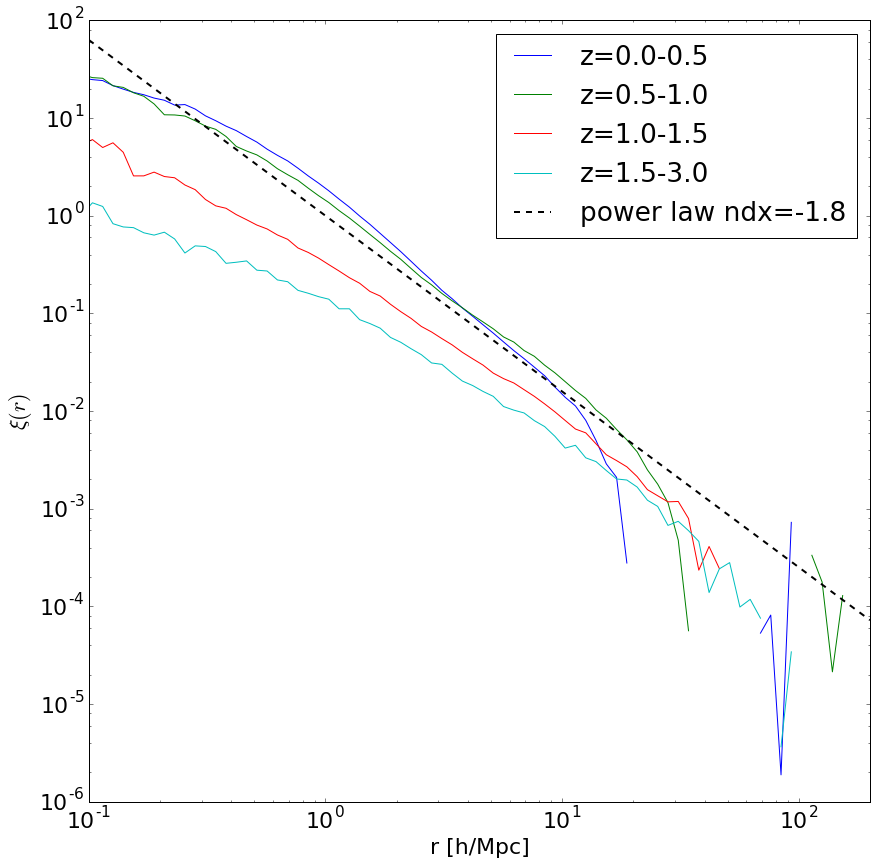

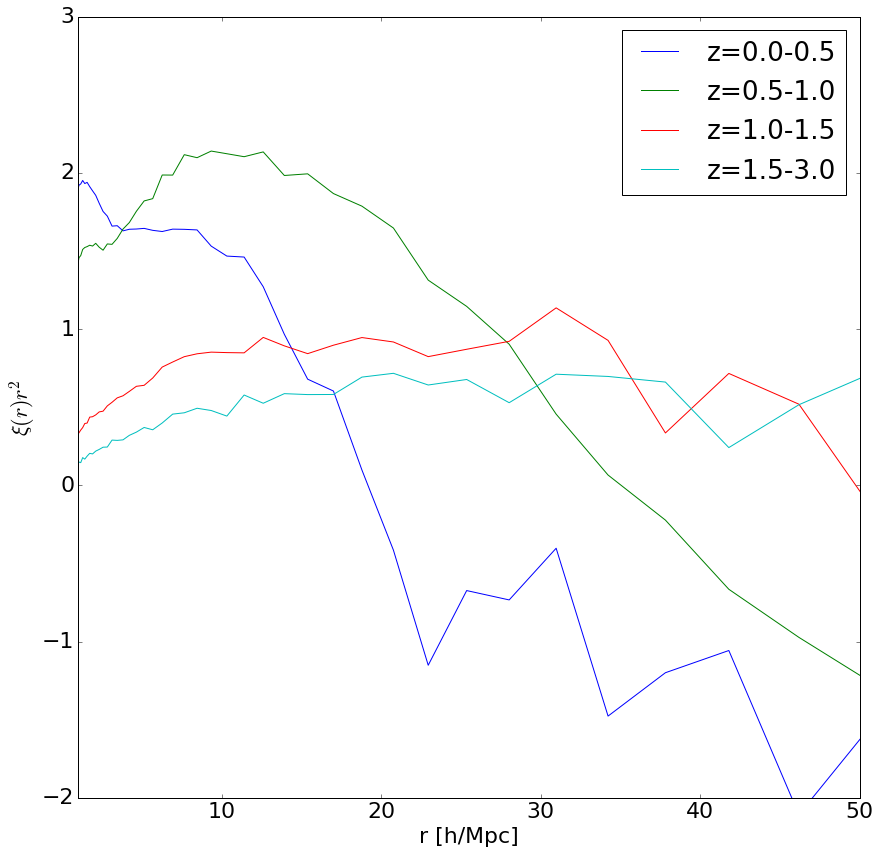

In [100]:
# plot
plt.figure(figsize=(14,14))
for zmin,zmax,rr,xi,xivar in xires:
    prr=rr*cosmo.h ## convert to Mpc/h
    plt.plot (prr,xi,label="z=%2.1f-%2.1f"%(zmin,zmax)) 
cx=logspace(log10(0.1),log10(200),10)
plt.plot (cx,cx**(-1.8),'k--',lw=2,label='power law ndx=-1.8')
plt.legend()
plt.loglog()
plt.xlim(0.1,200)
plt.xlabel("r [h/Mpc]")
plt.ylabel("$\\xi(r)$")

plt.figure(figsize=(14,14))
for zmin,zmax,rr,xi,xivar in xires:
    prr=rr*cosmo.h ## convert to Mpc/h
    plt.plot (prr,xi*prr*prr,label="z=%2.1f-%2.1f"%(zmin,zmax)) 
plt.legend()
plt.xlim(1,50)
plt.ylim(-2,3)
plt.xlabel("r [h/Mpc]")
plt.ylabel("$\\xi(r) r^2$")